<a href="https://colab.research.google.com/github/Mitroi-Silviu-Adrian/ML-CodeBert-DistinctSolutions/blob/main/ProblemsClasification%26Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install transformers

In [ ]:
!pip install transformers

Import everything we use:

In [ ]:
import gzip
import json
import logging
import os
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import torch
from sklearn.metrics import f1_score
from tokenizers.implementations.byte_level_bpe import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard.writer import SummaryWriter
from tqdm import tqdm, trange

from transformers import RobertaForSequenceClassification
from transformers.data.metrics import acc_and_f1, simple_accuracy

logging.basicConfig(level=logging.INFO)

Get Problem Names

In [ ]:
dataset_folder = "/content/drive/MyDrive/ProblemClassif/problems"

problemsNames = os.listdir(f"{dataset_folder}")

print(problemsNames)

['nrtri', 'sate', 'apm', 'ctc', 'dmin', 'cmap', 'swap', 'strmatch', 'schi', 'cmmdc', 'stramosi', 'party', 'inversmodular', 'inv', 'evaluare']


Get the Algorithm Solution Names

In [ ]:
algorithmSolutions = []
algorithmSolutionsFolders = [[]]

problemsDict = {}

for problem in problemsNames:
  problemFolder = dataset_folder + "/" + problem

  problemLabels = os.listdir(f"{problemFolder}")
  #print(problemLabels)

  problemSolFolders = []
  for alg in problemLabels:
    problemSolFolders.append(problemFolder + "/" + alg)
  #print(problemSolFolders)

  problemsDict[problem] = [problemLabels,problemSolFolders]

print(problemsDict)


ALG_LABELS = algorithmSolutions
FILES_PER_LANGUAGE = 1
EVALUATE = True

{'nrtri': [['cautareBinara', 'brute'], ['/content/drive/MyDrive/ProblemClassif/problems/nrtri/cautareBinara', '/content/drive/MyDrive/ProblemClassif/problems/nrtri/brute']], 'sate': [['bfs_lee', 'dfs', 'brute'], ['/content/drive/MyDrive/ProblemClassif/problems/sate/bfs_lee', '/content/drive/MyDrive/ProblemClassif/problems/sate/dfs', '/content/drive/MyDrive/ProblemClassif/problems/sate/brute']], 'apm': [['kruskal', 'prim'], ['/content/drive/MyDrive/ProblemClassif/problems/apm/kruskal', '/content/drive/MyDrive/ProblemClassif/problems/apm/prim']], 'ctc': [['tarjan', 'kosaraju'], ['/content/drive/MyDrive/ProblemClassif/problems/ctc/tarjan', '/content/drive/MyDrive/ProblemClassif/problems/ctc/kosaraju']], 'dmin': [['bellman', 'djikstra'], ['/content/drive/MyDrive/ProblemClassif/problems/dmin/bellman', '/content/drive/MyDrive/ProblemClassif/problems/dmin/djikstra']], 'cmap': [['distance_search', 'divide_conquer'], ['/content/drive/MyDrive/ProblemClassif/problems/cmap/distance_search', '/cont

Setup the Tokenizer and the TensorBoard

In [ ]:
# Set up tokenizer
tokenizer = ByteLevelBPETokenizer("/content/drive/MyDrive/ProblemClassif/vocab.json", "/content/drive/MyDrive/ProblemClassif/merges.txt",)
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")), ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)
# Set up Tensorboard
tb_writer = SummaryWriter()

Creation of train dataset class to handle each problem

In [ ]:
class ProblemClassifDataset(Dataset):
  examples: List[Tuple[List[int], int]]
  def __init__(self,split = "train",problemName = ""):
    self.examples = []

    labels = problemsDict[problemName][0]
    print(labels)
    noLabels = len(problemsDict[problemName])
    for i in range(noLabels):
      alg = problemsDict[problemName][0][i]

      folder = problemsDict[problemName][1][i] + "/" + split
      print(folder)

      problemsCodes = []

      for files in os.walk(f"{folder}"):
        for filename in files[2]:
          #print("   ->  " + filename)

          pathFile = folder + "/" + filename
          #print(pathFile)

          file = open(pathFile, mode='r')
          content = file.read()
          problemsCodes.append(content)

      examples = [(x.ids, labels.index(alg)) for x in tokenizer.encode_batch(problemsCodes)]
      self.examples += examples
    print("🔥🔥")
  def __len__(self):
        return len(self.examples)

  def __getitem__(self, i):
    # We’ll pad at the batch level.
    return self.examples[i]


Evaluation Function

In [ ]:

def evaluate():
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = np.empty((0), dtype=np.int64)
    out_label_ids = np.empty((0), dtype=np.int64)

    model.eval()

    eval_dataloader = DataLoader(eval_dataset, batch_size=256, collate_fn=collate)
    for step, (input_ids, labels) in enumerate(tqdm(eval_dataloader, desc="Eval")):
        with torch.no_grad():
            outputs = model(input_ids=input_ids.to("cuda"), labels=labels.to("cuda"))
            loss = outputs[0]
            logits = outputs[1]
            eval_loss += loss.mean().item()
            nb_eval_steps += 1
        preds = np.append(preds, logits.argmax(dim=1).detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, labels.detach().cpu().numpy(), axis=0)
    eval_loss = eval_loss / nb_eval_steps
    acc = simple_accuracy(preds, out_label_ids)
    f1 = f1_score(y_true=out_label_ids, y_pred=preds, average="macro")
    print()
    print("=== Eval: loss ===", eval_loss)
    print("=== Eval: acc. ===", acc)
    print("=== Eval: f1 ===", f1)
    print()

    epochResults.append([eval_loss,acc,f1])

    # print(acc_and_f1(preds, out_label_ids))
    tb_writer.add_scalars("eval", {"loss": eval_loss, "acc": acc, "f1": f1}, global_step)

Loading and Preapearing the model for Training

In [ ]:
results = []
for problem, data  in problemsDict.items():
  algLabels = data[0]

  print("Problem: " + problem)
  print("Algorithms: ")
  print(algLabels)
  print("Creation of the dataset for the problem")
  train_dataset = ProblemClassifDataset(split = "train",problemName = problem)
  eval_dataset = ProblemClassifDataset(split = "test",problemName = problem)
  print("Dataset done")
  print()
  print("Loading CodeBERTa")

  CODEBERTA_PRETRAINED = "huggingface/CodeBERTa-small-v1"

  model = RobertaForSequenceClassification.from_pretrained(CODEBERTA_PRETRAINED, num_labels=len(algLabels))

  def collate(examples):
      input_ids = pad_sequence([torch.tensor(x[0]) for x in examples], batch_first=True, padding_value=1)
      labels = torch.tensor([x[1] for x in examples])
      # ^^  uncessary .unsqueeze(-1)
      return input_ids, labels


  train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate)

  batch = next(iter(train_dataloader))

  model.to("cuda")
  model.train()
  for param in model.roberta.parameters():
      param.requires_grad = False
  ## ^^ Only train final layer.

  print(f"num params:", model.num_parameters())
  print(f"num trainable params:", model.num_parameters(only_trainable=True))
  print()
  print("Model loaded")
  print()
  print("Training Loop")

  global_step = 0
  train_iterator = trange(0, 20, desc="Epoch")
  optimizer = torch.optim.AdamW(model.parameters())

  epochIndex = -1
  evaluationAtEpoch = [1,5,10,20]
  epochResults = [[]]

  for _ in train_iterator:
      epoch_iterator = tqdm(train_dataloader, desc="Iteration")

      epochIndex += 1
      if(epochIndex in evaluationAtEpoch):
        print()
        print("Epoch " + str(epochIndex) + " Evaluation")
        evaluate()
        print()
      for step, (input_ids, labels) in enumerate(epoch_iterator):
          optimizer.zero_grad()
          outputs = model(input_ids=input_ids.to("cuda"), labels=labels.to("cuda"))
          loss = outputs[0]
          loss.backward()
          tb_writer.add_scalar("training_loss", loss.item(), global_step)
          optimizer.step()
          global_step += 1
          if EVALUATE and global_step % 50 == 0:
              #evaluate()
              model.train()
  print()
  print("Final Evaluation")
  evaluate()

  print()
  print("Training Done")
  print()
  print("Storing the results")
  problemResults = [problem]

  for result in epochResults:
    problemResults.extend(result)

  problemResults = ", ".join(map(str, problemResults))
  print(problemResults)
  results.append(problemResults)
  print("Done")
  os.makedirs("./models/CodeBERT-problem-id", exist_ok=True)
  model.save_pretrained("./models/CodeBERT-problem-id")


Problem: nrtri
Algorithms: 
['cautareBinara', 'brute']
Creation of the dataset for the problem
['cautareBinara', 'brute']
/content/drive/MyDrive/ProblemClassif/problems/nrtri/cautareBinara/train
/content/drive/MyDrive/ProblemClassif/problems/nrtri/brute/train
🔥🔥
['cautareBinara', 'brute']
/content/drive/MyDrive/ProblemClassif/problems/nrtri/cautareBinara/test
/content/drive/MyDrive/ProblemClassif/problems/nrtri/brute/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83452418
num trainable params: 592130

Model loaded

Training Loop


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 1.7038986682891846
=== Eval: acc. === 0.17391304347826086
=== Eval: f1 === 0.14814814814814817





Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.36874401569366455
=== Eval: acc. === 0.8260869565217391
=== Eval: f1 === 0.45238095238095233





Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.3641958236694336
=== Eval: acc. === 0.9130434782608695
=== Eval: f1 === 0.8578296703296704





Epoch: 100%|██████████| 20/20 [04:50<00:00, 14.54s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.3094286024570465
=== Eval: acc. === 0.8695652173913043
=== Eval: f1 === 0.8035431825371717


Training Done

Storing the results
nrtri, 1.7038986682891846, 0.17391304347826086, 0.14814814814814817, 0.36874401569366455, 0.8260869565217391, 0.45238095238095233, 0.3641958236694336, 0.9130434782608695, 0.8578296703296704, 0.3094286024570465, 0.8695652173913043, 0.8035431825371717
Done
Problem: sate
Algorithms: 
['bfs_lee', 'dfs', 'brute']
Creation of the dataset for the problem
['bfs_lee', 'dfs', 'brute']
/content/drive/MyDrive/ProblemClassif/problems/sate/bfs_lee/train
/content/drive/MyDrive/ProblemClassif/problems/sate/dfs/train
🔥🔥
['bfs_lee', 'dfs', 'brute']
/content/drive/MyDrive/ProblemClassif/problems/sate/bfs_lee/test
/content/drive/MyDrive/ProblemClassif/problems/sate/dfs/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83453187
num trainable params: 592899

Model loaded

Training Loop


Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:04<00:00,  4.08s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.5734885334968567
=== Eval: acc. === 0.75
=== Eval: f1 === 0.7309442150206482





Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.389171302318573
=== Eval: acc. === 0.7419354838709677
=== Eval: f1 === 0.572965992251399





Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.2661711871623993
=== Eval: acc. === 0.8870967741935484
=== Eval: f1 === 0.8790412486064659





Epoch: 100%|██████████| 20/20 [04:21<00:00, 13.10s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.2520027458667755
=== Eval: acc. === 0.8709677419354839
=== Eval: f1 === 0.8629455650732247


Training Done

Storing the results
sate, 0.5734885334968567, 0.75, 0.7309442150206482, 0.389171302318573, 0.7419354838709677, 0.572965992251399, 0.2661711871623993, 0.8870967741935484, 0.8790412486064659, 0.2520027458667755, 0.8709677419354839, 0.8629455650732247
Done
Problem: apm
Algorithms: 
['kruskal', 'prim']
Creation of the dataset for the problem
['kruskal', 'prim']
/content/drive/MyDrive/ProblemClassif/problems/apm/kruskal/train
/content/drive/MyDrive/ProblemClassif/problems/apm/prim/train
🔥🔥
['kruskal', 'prim']
/content/drive/MyDrive/ProblemClassif/problems/apm/kruskal/test
/content/drive/MyDrive/ProblemClassif/problems/apm/prim/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83452418
num trainable params: 592130

Model loaded

Training Loop


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 1.7151705026626587
=== Eval: acc. === 0.44
=== Eval: f1 === 0.3055555555555556





Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:05<00:00,  5.76s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.5093084573745728
=== Eval: acc. === 0.6685714285714286
=== Eval: f1 === 0.5837434383202099





Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:05<00:00,  5.76s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.25046488642692566
=== Eval: acc. === 0.8914285714285715
=== Eval: f1 === 0.8902676479324114





Epoch: 100%|██████████| 20/20 [05:39<00:00, 17.00s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.16300004720687866
=== Eval: acc. === 0.9428571428571428
=== Eval: f1 === 0.9410059331175836


Training Done

Storing the results
apm, 1.7151705026626587, 0.44, 0.3055555555555556, 0.5093084573745728, 0.6685714285714286, 0.5837434383202099, 0.25046488642692566, 0.8914285714285715, 0.8902676479324114, 0.16300004720687866, 0.9428571428571428, 0.9410059331175836
Done
Problem: ctc
Algorithms: 
['tarjan', 'kosaraju']
Creation of the dataset for the problem
['tarjan', 'kosaraju']
/content/drive/MyDrive/ProblemClassif/problems/ctc/tarjan/train
/content/drive/MyDrive/ProblemClassif/problems/ctc/kosaraju/train
🔥🔥
['tarjan', 'kosaraju']
/content/drive/MyDrive/ProblemClassif/problems/ctc/tarjan/test
/content/drive/MyDrive/ProblemClassif/problems/ctc/kosaraju/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83452418
num trainable params: 592130

Model loaded

Training Loop


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:05<00:00,  5.39s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.5719907283782959
=== Eval: acc. === 0.5828220858895705
=== Eval: f1 === 0.45474222746950016





Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:05<00:00,  5.39s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.5177400708198547
=== Eval: acc. === 0.6196319018404908
=== Eval: f1 === 0.5241996233521657





Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.2091735154390335
=== Eval: acc. === 0.9263803680981595
=== Eval: f1 === 0.9262443438914028





Epoch: 100%|██████████| 20/20 [05:48<00:00, 17.44s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:05<00:00,  5.40s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.14764051139354706
=== Eval: acc. === 0.9386503067484663
=== Eval: f1 === 0.9378052503052503


Training Done

Storing the results
ctc, 0.5719907283782959, 0.5828220858895705, 0.45474222746950016, 0.5177400708198547, 0.6196319018404908, 0.5241996233521657, 0.2091735154390335, 0.9263803680981595, 0.9262443438914028, 0.14764051139354706, 0.9386503067484663, 0.9378052503052503
Done
Problem: dmin
Algorithms: 
['bellman', 'djikstra']
Creation of the dataset for the problem
['bellman', 'djikstra']
/content/drive/MyDrive/ProblemClassif/problems/dmin/bellman/train
/content/drive/MyDrive/ProblemClassif/problems/dmin/djikstra/train
🔥🔥
['bellman', 'djikstra']
/content/drive/MyDrive/ProblemClassif/problems/dmin/bellman/test
/content/drive/MyDrive/ProblemClassif/problems/dmin/djikstra/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83452418
num trainable params: 592130

Model loaded

Training Loop


Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 2.40995717048645
=== Eval: acc. === 0.49
=== Eval: f1 === 0.32885906040268453





Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.9821498990058899
=== Eval: acc. === 0.49
=== Eval: f1 === 0.32885906040268453





Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.7135769724845886
=== Eval: acc. === 0.5
=== Eval: f1 === 0.3658041603247083





Epoch: 100%|██████████| 20/20 [03:30<00:00, 10.52s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.6160953044891357
=== Eval: acc. === 0.7
=== Eval: f1 === 0.6989160979526294


Training Done

Storing the results
dmin, 2.40995717048645, 0.49, 0.32885906040268453, 0.9821498990058899, 0.49, 0.32885906040268453, 0.7135769724845886, 0.5, 0.3658041603247083, 0.6160953044891357, 0.7, 0.6989160979526294
Done
Problem: cmap
Algorithms: 
['distance_search', 'divide_conquer']
Creation of the dataset for the problem
['distance_search', 'divide_conquer']
/content/drive/MyDrive/ProblemClassif/problems/cmap/distance_search/train
/content/drive/MyDrive/ProblemClassif/problems/cmap/divide_conquer/train
🔥🔥
['distance_search', 'divide_conquer']
/content/drive/MyDrive/ProblemClassif/problems/cmap/distance_search/test
/content/drive/MyDrive/ProblemClassif/problems/cmap/divide_conquer/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83452418
num trainable params: 592130

Model loaded

Training Loop


Iteration:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:06<00:00,  6.72s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.9236664772033691
=== Eval: acc. === 0.5621621621621622
=== Eval: f1 === 0.3709332101926871





Iteration:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.235647052526474
=== Eval: acc. === 0.9243243243243243
=== Eval: f1 === 0.9218372766779335





Iteration:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.10503128916025162
=== Eval: acc. === 0.9621621621621622
=== Eval: f1 === 0.9615144580819639





Epoch: 100%|██████████| 20/20 [06:23<00:00, 19.20s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.03750622645020485
=== Eval: acc. === 1.0
=== Eval: f1 === 1.0


Training Done

Storing the results
cmap, 0.9236664772033691, 0.5621621621621622, 0.3709332101926871, 0.235647052526474, 0.9243243243243243, 0.9218372766779335, 0.10503128916025162, 0.9621621621621622, 0.9615144580819639, 0.03750622645020485, 1.0, 1.0
Done
Problem: swap
Algorithms: 
['aib', 'merge']
Creation of the dataset for the problem
['aib', 'merge']
/content/drive/MyDrive/ProblemClassif/problems/swap/aib/train
/content/drive/MyDrive/ProblemClassif/problems/swap/merge/train
🔥🔥
['aib', 'merge']
/content/drive/MyDrive/ProblemClassif/problems/swap/aib/test
/content/drive/MyDrive/ProblemClassif/problems/swap/merge/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83452418
num trainable params: 592130

Model loaded

Training Loop


Iteration:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:05<00:00,  5.62s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 1.1621438264846802
=== Eval: acc. === 0.5348837209302325
=== Eval: f1 === 0.34848484848484845





Iteration:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:05<00:00,  5.67s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.5724323391914368
=== Eval: acc. === 0.627906976744186
=== Eval: f1 === 0.5992427552060579





Iteration:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:05<00:00,  5.64s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.3366178572177887
=== Eval: acc. === 0.8604651162790697
=== Eval: f1 === 0.860446247464503





Epoch: 100%|██████████| 20/20 [05:57<00:00, 17.86s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.20552943646907806
=== Eval: acc. === 0.9534883720930233
=== Eval: f1 === 0.9534317043454718


Training Done

Storing the results
swap, 1.1621438264846802, 0.5348837209302325, 0.34848484848484845, 0.5724323391914368, 0.627906976744186, 0.5992427552060579, 0.3366178572177887, 0.8604651162790697, 0.860446247464503, 0.20552943646907806, 0.9534883720930233, 0.9534317043454718
Done
Problem: strmatch
Algorithms: 
['z-algo', 'rk', 'kmp']
Creation of the dataset for the problem
['z-algo', 'rk', 'kmp']
/content/drive/MyDrive/ProblemClassif/problems/strmatch/z-algo/train
/content/drive/MyDrive/ProblemClassif/problems/strmatch/rk/train
🔥🔥
['z-algo', 'rk', 'kmp']
/content/drive/MyDrive/ProblemClassif/problems/strmatch/z-algo/test
/content/drive/MyDrive/ProblemClassif/problems/strmatch/rk/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83453187
num trainable params: 592899

Model loaded

Training Loop


Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.5537731051445007
=== Eval: acc. === 0.5042016806722689
=== Eval: f1 === 0.3756336149399733





Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.14628742635250092
=== Eval: acc. === 0.9327731092436975
=== Eval: f1 === 0.9325396825396826





Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.0520644411444664
=== Eval: acc. === 0.9915966386554622
=== Eval: f1 === 0.9915871332626369





Epoch: 100%|██████████| 20/20 [04:08<00:00, 12.40s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.010725561529397964
=== Eval: acc. === 1.0
=== Eval: f1 === 1.0


Training Done

Storing the results
strmatch, 0.5537731051445007, 0.5042016806722689, 0.3756336149399733, 0.14628742635250092, 0.9327731092436975, 0.9325396825396826, 0.0520644411444664, 0.9915966386554622, 0.9915871332626369, 0.010725561529397964, 1.0, 1.0
Done
Problem: schi
Algorithms: 
['treap', 'seg_tree', 'aib']
Creation of the dataset for the problem
['treap', 'seg_tree', 'aib']
/content/drive/MyDrive/ProblemClassif/problems/schi/treap/train
/content/drive/MyDrive/ProblemClassif/problems/schi/seg_tree/train
🔥🔥
['treap', 'seg_tree', 'aib']
/content/drive/MyDrive/ProblemClassif/problems/schi/treap/test
/content/drive/MyDrive/ProblemClassif/problems/schi/seg_tree/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83453187
num trainable params: 592899

Model loaded

Training Loop


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.42566657066345215
=== Eval: acc. === 1.0
=== Eval: f1 === 1.0





Iteration:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.09672615677118301
=== Eval: acc. === 1.0
=== Eval: f1 === 1.0





Iteration:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.018414009362459183
=== Eval: acc. === 1.0
=== Eval: f1 === 1.0





Epoch: 100%|██████████| 20/20 [02:10<00:00,  6.52s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.002474737586453557
=== Eval: acc. === 1.0
=== Eval: f1 === 1.0


Training Done

Storing the results
schi, 0.42566657066345215, 1.0, 1.0, 0.09672615677118301, 1.0, 1.0, 0.018414009362459183, 1.0, 1.0, 0.002474737586453557, 1.0, 1.0
Done
Problem: cmmdc
Algorithms: 
['bruteforce', 'Euclid-impartiri', 'Euclid-scaderi', 'BUILT_IN']
Creation of the dataset for the problem
['bruteforce', 'Euclid-impartiri', 'Euclid-scaderi', 'BUILT_IN']
/content/drive/MyDrive/ProblemClassif/problems/cmmdc/bruteforce/train
/content/drive/MyDrive/ProblemClassif/problems/cmmdc/Euclid-impartiri/train
🔥🔥
['bruteforce', 'Euclid-impartiri', 'Euclid-scaderi', 'BUILT_IN']
/content/drive/MyDrive/ProblemClassif/problems/cmmdc/bruteforce/test
/content/drive/MyDrive/ProblemClassif/problems/cmmdc/Euclid-impartiri/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83453956
num trainable params: 593668

Model loaded

Training Loop


Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.8707412481307983
=== Eval: acc. === 0.3644859813084112
=== Eval: f1 === 0.2671232876712329





Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.48171383142471313
=== Eval: acc. === 0.7289719626168224
=== Eval: f1 === 0.6162028447742733





Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.3132498562335968
=== Eval: acc. === 0.897196261682243
=== Eval: f1 === 0.8840736728060672





Epoch: 100%|██████████| 20/20 [03:12<00:00,  9.62s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.13611477613449097
=== Eval: acc. === 0.9439252336448598
=== Eval: f1 === 0.9380308880308881


Training Done

Storing the results
cmmdc, 0.8707412481307983, 0.3644859813084112, 0.2671232876712329, 0.48171383142471313, 0.7289719626168224, 0.6162028447742733, 0.3132498562335968, 0.897196261682243, 0.8840736728060672, 0.13611477613449097, 0.9439252336448598, 0.9380308880308881
Done
Problem: stramosi
Algorithms: 
['dp_log', 'lant']
Creation of the dataset for the problem
['dp_log', 'lant']
/content/drive/MyDrive/ProblemClassif/problems/stramosi/dp_log/train
/content/drive/MyDrive/ProblemClassif/problems/stramosi/lant/train
🔥🔥
['dp_log', 'lant']
/content/drive/MyDrive/ProblemClassif/problems/stramosi/dp_log/test
/content/drive/MyDrive/ProblemClassif/problems/stramosi/lant/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83452418
num trainable params: 592130

Model loaded

Training Loop


Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.594099760055542
=== Eval: acc. === 0.7241379310344828
=== Eval: f1 === 0.7043644472762026





Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.3123962879180908
=== Eval: acc. === 0.8448275862068966
=== Eval: f1 === 0.8446428571428573





Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.18184667825698853
=== Eval: acc. === 0.9310344827586207
=== Eval: f1 === 0.9305181191973644





Epoch: 100%|██████████| 20/20 [03:58<00:00, 11.93s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.08591359108686447
=== Eval: acc. === 0.9827586206896551
=== Eval: f1 === 0.9827380952380953


Training Done

Storing the results
stramosi, 0.594099760055542, 0.7241379310344828, 0.7043644472762026, 0.3123962879180908, 0.8448275862068966, 0.8446428571428573, 0.18184667825698853, 0.9310344827586207, 0.9305181191973644, 0.08591359108686447, 0.9827586206896551, 0.9827380952380953
Done
Problem: party
Algorithms: 
['tarjan', 'kosaraju', 'topsort']
Creation of the dataset for the problem
['tarjan', 'kosaraju', 'topsort']
/content/drive/MyDrive/ProblemClassif/problems/party/tarjan/train
/content/drive/MyDrive/ProblemClassif/problems/party/kosaraju/train
🔥🔥
['tarjan', 'kosaraju', 'topsort']
/content/drive/MyDrive/ProblemClassif/problems/party/tarjan/test
/content/drive/MyDrive/ProblemClassif/problems/party/kosaraju/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83453187
num trainable params: 592899

Model loaded

Training Loop


Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.5889514684677124
=== Eval: acc. === 0.7009345794392523
=== Eval: f1 === 0.6805970149253732





Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.4441766142845154
=== Eval: acc. === 0.794392523364486
=== Eval: f1 === 0.7942307692307693





Iteration:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.40476375818252563
=== Eval: acc. === 0.8411214953271028
=== Eval: f1 === 0.8410659676714723





Epoch: 100%|██████████| 20/20 [03:48<00:00, 11.42s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.305729478597641
=== Eval: acc. === 0.8598130841121495
=== Eval: f1 === 0.85961689845185


Training Done

Storing the results
party, 0.5889514684677124, 0.7009345794392523, 0.6805970149253732, 0.4441766142845154, 0.794392523364486, 0.7942307692307693, 0.40476375818252563, 0.8411214953271028, 0.8410659676714723, 0.305729478597641, 0.8598130841121495, 0.85961689845185
Done
Problem: inversmodular
Algorithms: 
['extended-euclid-algo', 'euler-toutient']
Creation of the dataset for the problem
['extended-euclid-algo', 'euler-toutient']
/content/drive/MyDrive/ProblemClassif/problems/inversmodular/extended-euclid-algo/train
/content/drive/MyDrive/ProblemClassif/problems/inversmodular/euler-toutient/train
🔥🔥
['extended-euclid-algo', 'euler-toutient']
/content/drive/MyDrive/ProblemClassif/problems/inversmodular/extended-euclid-algo/test
/content/drive/MyDrive/ProblemClassif/problems/inversmodular/euler-toutient/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83452418
num trainable params: 592130

Model loaded

Training Loop


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:04<00:00,  4.82s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 1.2831891775131226
=== Eval: acc. === 0.47333333333333333
=== Eval: f1 === 0.3212669683257918





Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.32500365376472473
=== Eval: acc. === 0.88
=== Eval: f1 === 0.876282991202346





Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:04<00:00,  4.92s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.12025777250528336
=== Eval: acc. === 0.9733333333333334
=== Eval: f1 === 0.9732142857142857





Epoch: 100%|██████████| 20/20 [05:22<00:00, 16.13s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.1135556548833847
=== Eval: acc. === 0.98
=== Eval: f1 === 0.9798918629071898


Training Done

Storing the results
inversmodular, 1.2831891775131226, 0.47333333333333333, 0.3212669683257918, 0.32500365376472473, 0.88, 0.876282991202346, 0.12025777250528336, 0.9733333333333334, 0.9732142857142857, 0.1135556548833847, 0.98, 0.9798918629071898
Done
Problem: inv
Algorithms: 
['aib', 'merge']
Creation of the dataset for the problem
['aib', 'merge']
/content/drive/MyDrive/ProblemClassif/problems/inv/aib/train
/content/drive/MyDrive/ProblemClassif/problems/inv/merge/train
🔥🔥
['aib', 'merge']
/content/drive/MyDrive/ProblemClassif/problems/inv/aib/test
/content/drive/MyDrive/ProblemClassif/problems/inv/merge/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83452418
num trainable params: 592130

Model loaded

Training Loop


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:04<00:00,  4.75s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.43593862652778625
=== Eval: acc. === 0.9246575342465754
=== Eval: f1 === 0.9246257098606092





Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:04<00:00,  4.83s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.2614586353302002
=== Eval: acc. === 0.910958904109589
=== Eval: f1 === 0.9102473164042181





Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:04<00:00,  4.78s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.07180590182542801
=== Eval: acc. === 0.9657534246575342
=== Eval: f1 === 0.9657518179685667





Epoch: 100%|██████████| 20/20 [05:13<00:00, 15.65s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:04<00:00,  4.74s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.02217804454267025
=== Eval: acc. === 1.0
=== Eval: f1 === 1.0


Training Done

Storing the results
inv, 0.43593862652778625, 0.9246575342465754, 0.9246257098606092, 0.2614586353302002, 0.910958904109589, 0.9102473164042181, 0.07180590182542801, 0.9657534246575342, 0.9657518179685667, 0.02217804454267025, 1.0, 1.0
Done
Problem: evaluare
Algorithms: 
['recursive', 'ast', 'stack']
Creation of the dataset for the problem
['recursive', 'ast', 'stack']
/content/drive/MyDrive/ProblemClassif/problems/evaluare/recursive/train
/content/drive/MyDrive/ProblemClassif/problems/evaluare/ast/train
🔥🔥
['recursive', 'ast', 'stack']
/content/drive/MyDrive/ProblemClassif/problems/evaluare/recursive/test
/content/drive/MyDrive/ProblemClassif/problems/evaluare/ast/test
🔥🔥
Dataset done

Loading CodeBERTa


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at huggingface/CodeBERTa-small-v1 and a

num params: 83453187
num trainable params: 592899

Model loaded

Training Loop


Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:05<00:00,  5.24s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.29744309186935425
=== Eval: acc. === 0.9627329192546584
=== Eval: f1 === 0.962206572769953





Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 5 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:05<00:00,  5.27s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.06827185302972794
=== Eval: acc. === 0.9751552795031055
=== Eval: f1 === 0.9747252747252747





Iteration:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 10 Evaluation




Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval: 100%|██████████| 1/1 [00:05<00:00,  5.31s/it]
/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



=== Eval: loss === 0.023389237001538277
=== Eval: acc. === 0.9937888198757764
=== Eval: f1 === 0.993647662260801





Epoch: 100%|██████████| 20/20 [05:42<00:00, 17.14s/it]



Final Evaluation


Eval: 100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


=== Eval: loss === 0.013051098212599754
=== Eval: acc. === 0.9937888198757764
=== Eval: f1 === 0.993647662260801


Training Done

Storing the results
evaluare, 0.29744309186935425, 0.9627329192546584, 0.962206572769953, 0.06827185302972794, 0.9751552795031055, 0.9747252747252747, 0.023389237001538277, 0.9937888198757764, 0.993647662260801, 0.013051098212599754, 0.9937888198757764, 0.993647662260801
Done



/usr/local/lib/python3.7/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Saving Results in file

In [ ]:
print()
print("Writing in a .csv file the results")

resultFile = open("results.csv","w")
resultFile.write("Problem,Loss - e1,Acc -e1,F1 - e1,Loss - e5,	Acc -e5,F1 - e5,Loss - e10,Acc -e10,F1 - e10,Loss - e20,Acc -e20,F1 - e20\n")
resultFile.close()
resultFile = open("results.csv","a")

print(results)
for result in results:
  resultFile.write(result)
  resultFile.write("\n")



Install pandas


In [ ]:
!pip install pandas
!pip install matplotlib

Importing Aditional Libraries



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('bmh')
fig = plt.figure(figsize=(8,6))

<Figure size 576x432 with 0 Axes>

Reading From the CSV file & Displaying the results


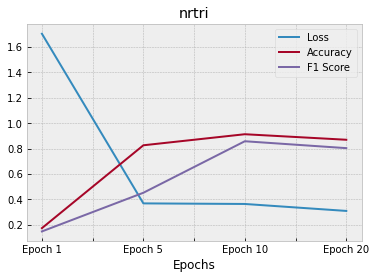

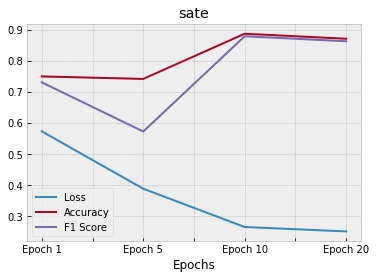

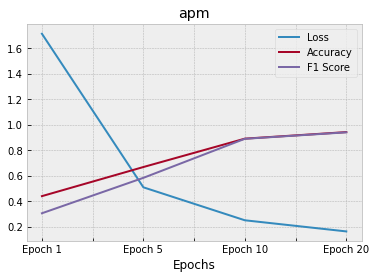

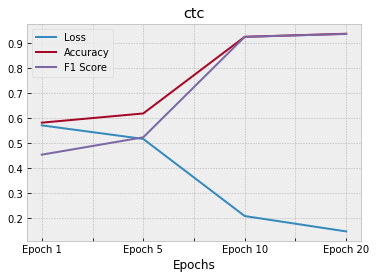

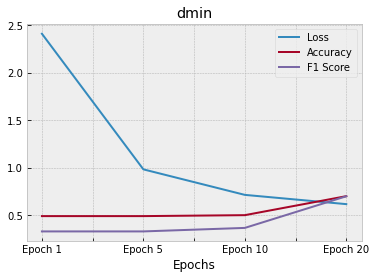

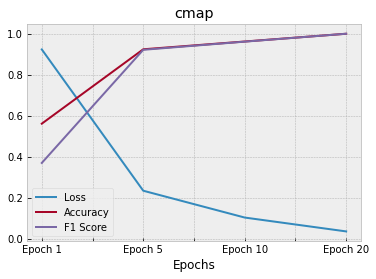

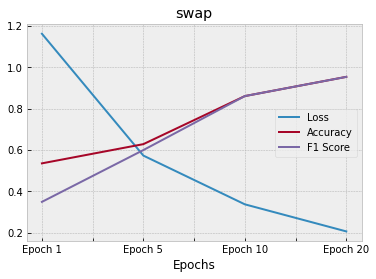

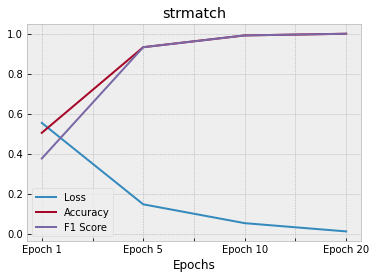

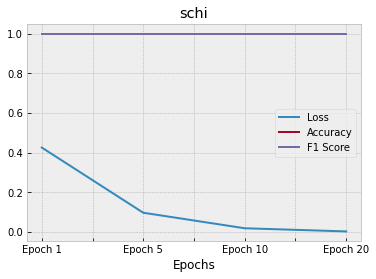

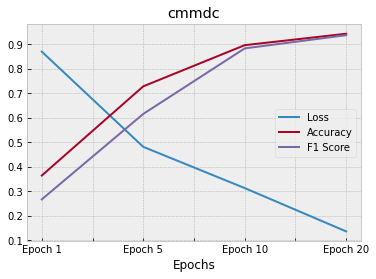

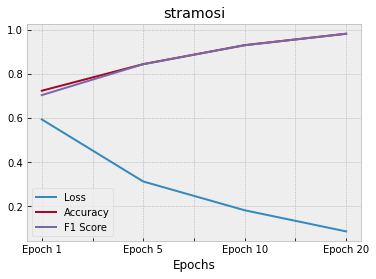

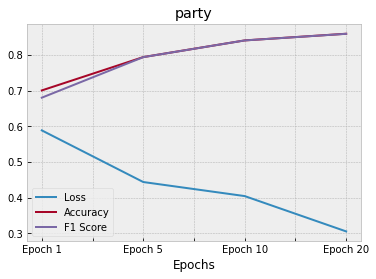

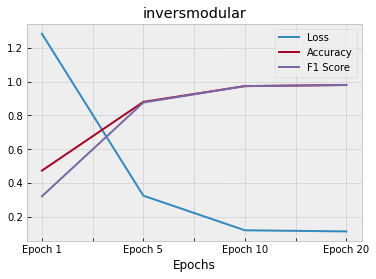

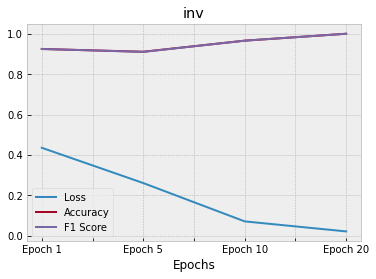

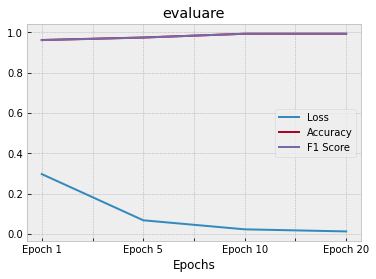

In [ ]:
problemsResults = pd.read_csv('results.csv').to_records()

headers = list(pd.read_csv('results.csv').columns)

PROBLEM_NAME_INDEX = 1
LOSS_INDICES = [2,5,8,11]
ACC_INDICES = [3,6,9,12]
F1_INDICES = [4,7,10,13]

for problemResult in problemsResults:
  problemName = problemResult[PROBLEM_NAME_INDEX]
  loss = [problemResult[index] for index in LOSS_INDICES]
  acc = [problemResult[index] for index in ACC_INDICES]
  f1 = [problemResult[index] for index in F1_INDICES]

  df = pd.DataFrame(
      data = {
          'Loss' : loss,
          'Accuracy': acc,
          'F1 Score': f1
      },
      index = ['Epoch 1','Epoch 5','Epoch 10','Epoch 20']
  )
  
  lines = df.plot(xlabel = 'Epochs', title = problemName)